## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-02-25 16:18:01--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  16.7MB/s    in 0.3s    

2025-02-25 16:18:01 (16.7 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [75]:
import math
import time

import pandas as pd
import numpy as np
from typing import Union

import matplotlib.pyplot as plt
from scipy.sparse import coo_array, csr_matrix
import implicit

In [55]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    # Определяем количество пользователей и айтемов
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    # Инициализируем матрицу нулями нужной формы
    result = np.zeros((n_users, n_items))
    # Заполняем матрицу: для каждой строки датафрейма
    # в позиции (user_id, item_id) записываем rating
    result[df['user_id'].values, df['item_id'].values] = df['rating'].values
    return result

In [10]:
interactions = df_to_matrix(df_train)

In [57]:
interactions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [11]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    # Собираем данные для разреженной матрицы
    data = df['rating'].values
    row  = df['user_id'].values
    col  = df['item_id'].values
    shape = (df['user_id'].max() + 1, df['item_id'].max() + 1)
    # Создаем разреженную матрицу в формате COO
    result = coo_array((data, (row, col)), shape=shape)
    return result

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [17]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # Если interractions - плотная матрица
    if isinstance(interractions, np.ndarray):
        # Если тип данных не плавающий, приводим к float
        if not np.issubdtype(interractions.dtype, np.floating):
            interractions = interractions.astype(np.float64)
        if n_singular_values == -1:
            U, s, Vh = np.linalg.svd(interractions, full_matrices=False)
        else:
            U, s, Vh = np.linalg.svd(interractions, full_matrices=False)
            U, s, Vh = U[:, :n_singular_values], s[:n_singular_values], Vh[:n_singular_values, :]
        S = np.diag(s)
        return U, S, Vh
    else:
        # Для разрежённой матрицы
        from scipy.sparse.linalg import svds
        # Приводим данные к типу float, если это необходимо
        if not np.issubdtype(interractions.dtype, np.floating):
            interractions = interractions.astype(np.float64)
        m, n = interractions.shape
        # Если n_singular_values = -1, берем k = min(m, n) - 1, иначе - заданное число
        k = min(m, n) - 1 if n_singular_values == -1 else n_singular_values
        U, s, Vt = svds(interractions, k=k)
        # svds возвращает сингулярные числа в возрастающем порядке, поэтому сортируем по убыванию
        idx = np.argsort(s)[::-1]
        U, s, Vt = U[:, idx], s[idx], Vt[idx, :]
        S = np.diag(s)
        return U, S, Vt

In [19]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [18]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [20]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array],
                             n_singular_values: int = -1, top_k: int = 100):
    # Получаем SVD-разложение: U, S, V
    U, S, V = make_svd(interractions, n_singular_values)
    # Восстанавливаем приближенную матрицу интеракций
    reconstructed = U @ S @ V

    # Если исходная матрица представлена в разрежённом формате, приводим её к плотному виду
    if not isinstance(interractions, np.ndarray):
        original = interractions.toarray()
    else:
        original = interractions

    # Не рекомендуем айтемы, с которыми пользователь уже взаимодействовал:
    # для таких позиций обнуляем (или, точнее, выставляем -inf, чтобы они не попадали в top)
    reconstructed[original != 0] = -np.inf

    # Для каждого пользователя выбираем индексы top_k наивысших оценок (сортируем по убыванию)
    recommendations = np.argsort(-reconstructed, axis=1)[:, :top_k]
    return recommendations

In [22]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [27]:
def ndcg_at_k(recs: np.ndarray, test_matrix: np.ndarray, k: int) -> float:
    """
    Вычисляет среднее значение NDCG@k по всем пользователям

    recs: массив формы [n_users, k] с индексами рекомендованных айтемов
    test_matrix: плотная матрица тестовых интеракций (значение > 0 означает наличие интеракции)
    k: число рекомендаций
    """
    n_users = recs.shape[0]
    ndcg_scores = []
    for i in range(n_users):
        # Находим релевантные айтемы для пользователя
        true_items = set(np.where(test_matrix[i] > 0)[0])
        if not true_items:
            continue
        dcg = 0.0
        idcg = 0.0
        for rank, item in enumerate(recs[i]):
            if item in true_items:
                dcg += 1.0 / np.log2(rank + 2)  # +2, т.к. rank начинается с 0
        ideal_rels = min(len(true_items), k)
        for rank in range(ideal_rels):
            idcg += 1.0 / np.log2(rank + 2)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0)
    return np.mean(ndcg_scores) if ndcg_scores else 0

def plot_graphs(interractions: Union[np.ndarray, coo_array], top_k: int = 100):
    """
    Для каждого значения n_singular_values из списка [1, 10, 50, 200, 1000]:
      - Вычисляет рекомендации с помощью SVD
      - Замеряет время вычисления
      - Оценивает качество рекомендаций по метрике NDCG на тестовой матрице (test_matrix)

    В конце строит два графика:
      1. Зависимость NDCG от числа сингулярных значений
      2. Зависимость времени выполнения от числа сингулярных значений

    В этом примере test_matrix считается глобальной переменной, полученной, например, так:
      test_matrix = df_to_matrix(df_test)
    """
    singular_values_list = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    runtimes = []

    for n_singular in singular_values_list:
        start_time = time.time()
        # Вычисляем рекомендации для заданного числа сингулярных значений
        recs = make_svd_recommendations(interractions, n_singular, top_k)
        elapsed_time = time.time() - start_time
        runtimes.append(elapsed_time)

        # Оценка качества по метрике NDCG (тестовая матрица test_matrix должна быть определена)
        score = ndcg_at_k(recs, test_matrix, top_k)
        ndcg_scores.append(score)
        print(f"n_singular_values = {n_singular}: NDCG = {score:.4f}, время = {elapsed_time:.4f} сек")

    # Построение графиков
    plt.figure(figsize=(12, 5))

    # График зависимости NDCG от числа сингулярных значений
    plt.subplot(1, 2, 1)
    plt.plot(singular_values_list, ndcg_scores, marker='o')
    plt.xlabel("Количество сингулярных значений")
    plt.ylabel("NDCG")
    plt.title("Зависимость NDCG от числа сингулярных значений")

    # График зависимости времени выполнения от числа сингулярных значений
    plt.subplot(1, 2, 2)
    plt.plot(singular_values_list, runtimes, marker='o', color='red')
    plt.xlabel("Количество сингулярных значений")
    plt.ylabel("Время выполнения (сек)")
    plt.title("Время работы алгоритма от числа сингулярных значений")

    plt.tight_layout()
    plt.show()

# Пример вызова функции:
# Предполагается, что:
#   - coo_interactions - разрежённая матрица интеракций, полученная через df_to_coo(df_train)
#   - test_matrix - плотная матрица тестовых интеракций, полученная через df_to_matrix(df_test)
# Например:
# test_matrix = df_to_matrix(df_test)
# plot_graphs(coo_interactions)


In [28]:
test_matrix = df_to_matrix(df_test)

n_singular_values = 1: NDCG = 0.2427, время = 2.7807 сек
n_singular_values = 10: NDCG = 0.2754, время = 2.0366 сек
n_singular_values = 50: NDCG = 0.2535, время = 2.9583 сек
n_singular_values = 200: NDCG = 0.1934, время = 10.3711 сек
n_singular_values = 1000: NDCG = 0.0738, время = 75.5877 сек


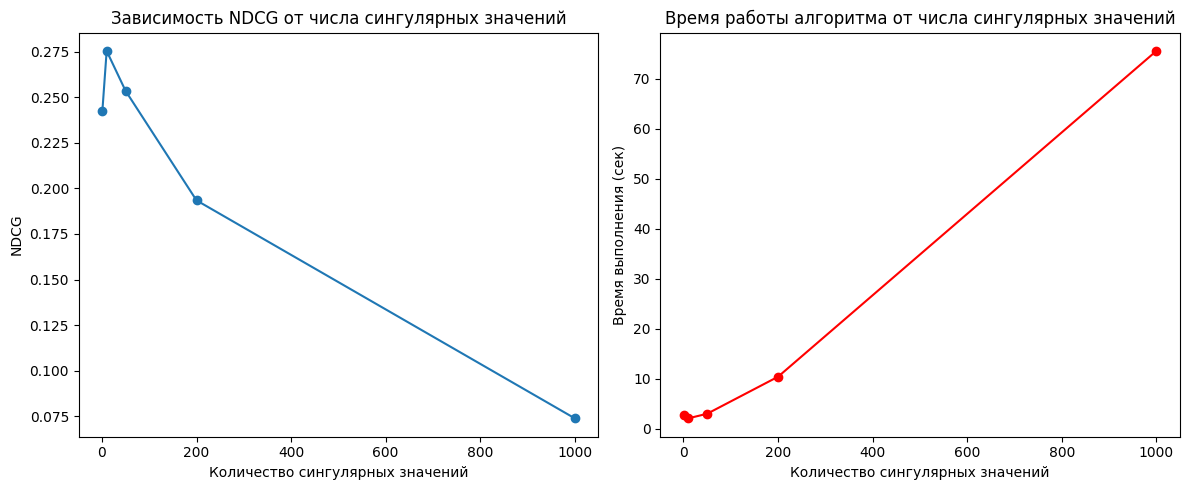

In [29]:
plot_graphs(coo_interactions)

выбирая оптимальное число сингулярных значений, важно находить баланс между качеством (NDCG) и скоростью работы

По результатам, представленным на графиках, разумным компромиссом может быть диапазон 10–50 факторов, где качество высокое, а время ещё не слишком велико

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [31]:
!pip install -q implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 41.2 MB/s eta 0:00:00


In [48]:


def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    """
    Обучает ALS (iALS) на заданной матрице интеракций и возвращает top_k рекомендаций для каждого пользователя.

    Параметры:
      interractions: матрица интеракций [n_users, n_items] (плотная или разрежённая)
      top_k: число рекомендаций на пользователя
      n_factors: число латентных факторов
      alpha: коэффициент для масштабирования confidence (confidence = 1 + alpha * R)
      regularization: коэффициент регуляризации

    Возвращает:
      recommendations: np.ndarray размера [n_users, top_k] с индексами рекомендованных айтемов.
                       Если рекомендаций меньше top_k, оставшиеся места заполняются -1.
    """
    # Приводим входные данные к формату CSR (user-item)
    if isinstance(interractions, np.ndarray):
        user_item_data = csr_matrix(interractions, dtype=np.float32)
    else:
        user_item_data = interractions.tocsr().astype(np.float32)

    # Транспонируем для обучения: получаем матрицу item-user и снова приводим к CSR
    item_user_data = user_item_data.T.tocsr()

    # Применяем масштабирование alpha (confidence = 1 + alpha * R)
    item_user_data = item_user_data * alpha

    # Обучаем модель ALS на матрице item-user
    model = implicit.als.AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=15,
        random_state=42
    )
    model.fit(item_user_data)

    # Определяем общее число пользователей из исходной матрицы (user_item_data.shape[0])
    n_total = user_item_data.shape[0]

    # Для пользователей с нулевыми интеракциями выдадим дефолтные рекомендации по популярности.
    # Вычисляем популярность каждого айтема как сумму интеракций по всем пользователям.
    popularity = np.array(user_item_data.sum(axis=0)).ravel()
    default_recs = np.argsort(-popularity)[:top_k]

    recommendations = np.zeros((n_total, top_k), dtype=np.int32)

    for user_id in range(n_total):
        user_vector = user_item_data.getrow(user_id)  # (1, n_items)
        # Если у пользователя нет интеракций, используем дефолтные рекомендации
        if user_vector.nnz == 0:
            recs_for_user = list(default_recs)
        else:
            # Попытка получить рекомендации через модель
            try:
                recs_for_user = model.recommend(
                    userid=user_id,
                    user_items=user_vector,
                    N=top_k,
                    filter_already_liked_items=True
                )
                recs_for_user = [rec[0] for rec in recs_for_user]
            except Exception as e:
                # В случае ошибки выдаем дефолтные рекомендации
                recs_for_user = list(default_recs)

        # Если рекомендаций меньше top_k, дополняем -1
        if len(recs_for_user) < top_k:
            recs_for_user += [-1] * (top_k - len(recs_for_user))
        recommendations[user_id, :] = recs_for_user[:top_k]

    return recommendations


In [49]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [50]:
interactions.shape[0]

5365

In [51]:
recs.shape

(5365, 100)

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [ ]:
# мы уже обучали модель, есть объект item_le, на основе которого преобразовывали df_train['item_id']

# item_le.classes_ содержит отсортированные оригинальные movie_id

# Считываем movies.dat один раз и формируем словарь mapping:
movies_df = pd.read_csv(
    "ml-1m/movies.dat",
    sep="::",
    header=None,
    names=["movie_id", "title", "genres"],
    engine="python",
    encoding="latin-1"
)
# Формируем словарь: {movie_id: title}
movies_mapping = dict(zip(movies_df["movie_id"], movies_df["title"]))

In [73]:
def get_movie_title(internal_id):
    """
    Функция для получения названия фильма по внутреннему индексу
    """
    try:
        original_id = item_le.inverse_transform([internal_id])[0]
    except ValueError:
        return "Unknown"
    return movies_mapping.get(original_id, "Unknown")

def human_readable_explanation(user_id, user_vector, item_id, als_model, top_contributions=3):
    """
    Получает объяснение для рекомендации и возвращает человекочитаемую строку.

    Параметры:
      user_id: внутренний индекс пользователя
      user_vector: вектор интеракций пользователя (1 x n_items, csr_matrix)
      item_id: внутренний индекс рекомендованного айтема
      als_model: обученная модель ALS
      top_contributions: сколько наиболее значимых вкладов показать

    Возвращает:
      строку с объяснением рекомендации.
    """
    try:
        # Получаем внутреннее объяснение; формат: (final_score, contributions, latent_factors, flag)
        expl = als_model.explain(user_id, user_vector, item_id)
    except Exception as e:
        return "Объяснение недоступно"

    final_score = expl[0]
    contributions = expl[1]  # список кортежей (other_item, weight)

    # Отбираем top_contributions вкладов по убыванию веса
    contributions_sorted = sorted(contributions, key=lambda x: x[1], reverse=True)
    top_contribs = contributions_sorted[:top_contributions]

    # Формируем читаемое объяснение
    parts = []
    for contrib_item, weight in top_contribs:
        title = get_movie_title(contrib_item)
        parts.append(f"{title} (вес {weight:.3f})")

    explanation_text = ", ".join(parts)
    return f"Базируется на похожих фильмах: {explanation_text} (итоговый вклад: {final_score:.3f})"

# Выбираем несколько пользователей для демонстрации объяснения рекомендаций
sample_user_ids = [0, 10]

for user_id in sample_user_ids:
    # Получаем вектор интеракций для пользователя (1 x n_items)
    user_vector = user_item_data.getrow(user_id)

    # Получаем топ-5 рекомендаций для пользователя (метод возвращает кортеж: (item_ids, scores))
    recs = als_model.recommend(
        userid=user_id,
        user_items=user_vector,
        N=5,
        filter_already_liked_items=True
    )

    # Распаковываем рекомендации: item_ids и соответствующие им scores
    item_ids, scores = recs
    print(f"\nРекомендации для пользователя {user_id}:")
    for internal_item_id, score in zip(item_ids, scores):
        explanation = human_readable_explanation(user_id, user_vector, internal_item_id, als_model)
        movie_title = get_movie_title(internal_item_id)
        print(f"  Фильм: {movie_title} (ID: {internal_item_id}), score: {score:.4f}")
        print(f"    Объяснение: {explanation}")


Рекомендации для пользователя 0:
  Фильм: Somewhere in Time (1980) (ID: 963), score: 1.4662
    Объяснение: Базируется на похожих фильмах: Taxi Driver (1976) (вес 0.022), Girlfight (2000) (вес 0.018), Midnight Cowboy (1969) (вес 0.018) (итоговый вклад: 0.105)
  Фильм: Buffy the Vampire Slayer (1992) (ID: 2481), score: 1.4317
    Объяснение: Базируется на похожих фильмах: Taxi Driver (1976) (вес 0.014), Wallace & Gromit: The Best of Aardman Animation (1996) (вес 0.009), 400 Blows, The (Les Quatre cents coups) (1959) (вес 0.009) (итоговый вклад: 0.040)
  Фильм: Wild Bill (1995) (ID: 169), score: 1.4178
    Объяснение: Базируется на похожих фильмах: Girlfight (2000) (вес 0.032), Secrets & Lies (1996) (вес 0.018), Hamlet (1964) (вес 0.016) (итоговый вклад: 0.037)
  Фильм: Unknown (ID: 4408), score: 1.4007
    Объяснение: Базируется на похожих фильмах: Conversation, The (1974) (вес 0.022), Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) (вес 0.022), Dog Day Afternoon (1975) (вес 0.012

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [74]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    """
    Функция преобразования обучающей выборки в плотную матрицу
    """
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    result = np.zeros((n_users, n_items))
    result[df['user_id'].values, df['item_id'].values] = df['rating'].values
    return result

# 1. Бинаризация: любая интеракция → 1
def transform_binary(df: pd.DataFrame) -> pd.DataFrame:
    df_bin = df.copy()
    df_bin['rating'] = 1
    return df_bin

# 2. Рейтинги: если рейтинг >=4, то 1, иначе 0
def transform_1_0(df: pd.DataFrame) -> pd.DataFrame:
    df_trans = df.copy()
    df_trans['rating'] = df_trans['rating'].apply(lambda r: 1 if r >= 4 else 0)
    return df_trans

# 3. Рейтинги: если рейтинг >=4, то 1, иначе -1
def transform_1_minus1(df: pd.DataFrame) -> pd.DataFrame:
    df_trans = df.copy()
    df_trans['rating'] = df_trans['rating'].apply(lambda r: 1 if r >= 4 else -1)
    return df_trans

# 4. Рейтинги с временным сглаживанием:
#    Если рейтинг >=4, ставим 1, иначе -1, но умножаем на коэффициент, зависящий от разницы в днях между максимальной датой и датой интеракции.
def transform_1_minus1_time(df: pd.DataFrame, lambda_val=0.01) -> pd.DataFrame:
    df_trans = df.copy()
    max_date = df_trans['datetime'].max()
    # Вычисляем разницу в днях для каждой интеракции
    df_trans['days_diff'] = (max_date - df_trans['datetime']).dt.days
    # Вычисляем коэффициент сглаживания: чем больше дней, тем меньше вес (экспоненциальный спад)
    df_trans['time_weight'] = df_trans['days_diff'].apply(lambda d: math.exp(-lambda_val * d))
    # Применяем преобразование рейтинга с учетом time_weight
    df_trans['rating'] = df_trans.apply(lambda row: (1 if row['rating'] >= 4 else -1) * row['time_weight'], axis=1)
    # Удаляем вспомогательные столбцы
    df_trans.drop(columns=['days_diff', 'time_weight'], inplace=True)
    return df_trans

# Словарь с вариантами преобразования
transforms = {
    "binary": transform_binary,
    "1_0": transform_1_0,
    "1_-1": transform_1_minus1,
    "1_-1_time": transform_1_minus1_time
}

# у нас уже есть:
# - df_train и df_test, где df_train использовался для обучения
# - test_matrix = df_to_matrix(df_test) (тестовая матрица оставляем неизменной)

# Для оценки качества используем метрику NDCG, функцию ndcg_at_k
# Также используются функции make_als_recommendations и make_svd_recommendations для получения рекомендаций

# Пример цикла по вариантам преобразования:
print("Сравнение метрик для различных преобразований обучающей выборки:")
for name, func in transforms.items():
    df_train_trans = func(df_train)
    train_matrix = df_to_matrix(df_train_trans)

    # Получаем рекомендации через SVD (полное разложение)
    svd_recs = make_svd_recommendations(train_matrix, n_singular_values=-1, top_k=100)
    svd_ndcg = ndcg_at_k(svd_recs, test_matrix, 100)

    # Получаем рекомендации через ALS
    als_recs = make_als_recommendations(train_matrix)
    als_ndcg = ndcg_at_k(als_recs, test_matrix, 100)

    print(f"Преобразование: {name}")
    print(f"   SVD NDCG: {svd_ndcg:.4f}")
    print(f"   ALS NDCG: {als_ndcg:.4f}\n")

Сравнение метрик для различных преобразований обучающей выборки:


  0%|          | 0/15 [00:00<?, ?it/s]

Преобразование: binary
   SVD NDCG: 0.1215
   ALS NDCG: 0.0426



  0%|          | 0/15 [00:00<?, ?it/s]

Преобразование: 1_0
   SVD NDCG: 0.1038
   ALS NDCG: 0.0448



  0%|          | 0/15 [00:00<?, ?it/s]

Преобразование: 1_-1
   SVD NDCG: 0.0877
   ALS NDCG: 0.0434



  0%|          | 0/15 [00:00<?, ?it/s]

Преобразование: 1_-1_time
   SVD NDCG: 0.0949
   ALS NDCG: 0.0472



##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [76]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        """
        Параметры:
          n_factors: число латентных факторов (f)
          alpha: коэффициент для вычисления уверенности, c[u,i] = 1 + alpha * R[u,i]
          reg_coef: коэффициент регуляризации (λ)
        """
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.X = None  # Факторы пользователей (матрица размером m x f)
        self.Y = None  # Факторы айтемов (матрица размером n x f)
        self.fitted = False

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        """
        Обучает модель на основе входной плотной матрицы интеракций R (размер m x n),
        где R[u, i] — количество взаимодействий (или рейтинг)

        Используем:
          p[u,i] = 1 если R[u,i] > 0, иначе 0 (бинарные предпочтения)
          c[u,i] = 1 + alpha * R[u,i]  (уверенность)

        Обновление факторов:
          Для пользователя u:
            X[u] = (YᵀY + Σ_{i: p[u,i]=1} (c[u,i]-1) * y[i]y[i]ᵀ + λI)⁻¹ · (Σ_{i: p[u,i]=1} c[u,i]* y[i])
          Аналогично для айтема i.
        """
        m, n = interactions.shape
        # Бинарная матрица предпочтений
        p = (interactions > 0).astype(np.float32)
        # Матрица уверенности
        c = 1 + self.alpha * interactions  # shape (m, n)

        f = self.n_factors
        reg = self.reg_coef
        I_f = np.eye(f, dtype=np.float32)

        # Инициализируем факторы случайными значениями
        self.X = np.random.rand(m, f).astype(np.float32)
        self.Y = np.random.rand(n, f).astype(np.float32)

        # Альтернативное обновление: сначала пользователей, затем айтемы
        for it in range(n_iterations):
            # Предвычисляем YᵀY (f x f)
            YTY = self.Y.T.dot(self.Y)
            # Обновление для каждого пользователя u
            for u in range(m):
                indices = np.where(p[u] > 0)[0]  # айтемы, где есть взаимодействие
                A = YTY.copy()
                if indices.size > 0:
                    for i in indices:
                        A += (c[u, i] - 1) * np.outer(self.Y[i], self.Y[i])
                    b = np.sum((c[u, indices][:, None]) * self.Y[indices], axis=0)
                else:
                    b = np.zeros(f, dtype=np.float32)
                A += reg * I_f
                self.X[u] = np.linalg.solve(A, b)

            # Предвычисляем XᵀX (f x f)
            XTX = self.X.T.dot(self.X)
            # Обновление для каждого айтема i
            for i in range(n):
                indices = np.where(p[:, i] > 0)[0]
                A = XTX.copy()
                if indices.size > 0:
                    for u in indices:
                        A += (c[u, i] - 1) * np.outer(self.X[u], self.X[u])
                    b = np.sum((c[indices, i][:, None]) * self.X[indices], axis=0)
                else:
                    b = np.zeros(f, dtype=np.float32)
                A += reg * I_f
                self.Y[i] = np.linalg.solve(A, b)

        self.fitted = True
        self._p = p  # сохраняем бинарную матрицу предпочтений для predict
        return self

    def predict(self, top_k: int = 100):
        """
        Возвращает для каждого пользователя топ_k рекомендованных айтемов

        При этом айтемы, с которыми пользователь уже взаимодействовал (p[u,i]==1), исключаются

        Возвращает:
          predicts: numpy-массив размера (m, top_k) с индексами рекомендованных айтемов
        """
        if not self.fitted:
            raise ValueError("Модель не обучена. Вызовите fit() перед predict().")
        m, n = self._p.shape
        # Предсказанные предпочтения: X · Yᵀ, shape (m, n)
        scores = self.X.dot(self.Y.T)
        # Исключаем айтемы, с которыми уже было взаимодействие
        scores[self._p > 0] = -np.inf

        predicts = np.zeros((m, top_k), dtype=np.int32)
        for u in range(m):
            top_items = np.argpartition(-scores[u], top_k)[:top_k]
            top_items = top_items[np.argsort(-scores[u, top_items])]
            predicts[u] = top_items
        return predicts

In [77]:
model = iALS(n_factors=100, alpha=40, reg_coef=0.01)

# Обучаем модель на матрице интеракций
model.fit(interactions, n_iterations=10)

# Получаем топ-100 рекомендаций для каждого пользователя
predictions = model.predict(top_k=100)

print("Размерность рекомендаций:", predictions.shape)

Размерность рекомендаций: (5365, 100)


In [78]:
predictions

array([[ 544, 2831, 2251, ..., 2374, 1961, 2630],
       [ 929,  638,  900, ..., 2284,  933,  661],
       [1617,  664, 1425, ..., 2364, 1467,   47],
       ...,
       [ 670, 1433,  936, ..., 2034, 1711, 2766],
       [ 873,  656,  924, ..., 2729, 1424, 1703],
       [1719, 2943, 1428, ..., 2175, 1425,  943]], dtype=int32)